<a href="https://colab.research.google.com/github/MarkAvilin1/DS-and-ML/blob/main/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание уровень Ultra Pro

In [ ]:
import numpy as np
import pandas as pd 

from tensorflow.keras.models import Sequential, Model  
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten 
from tensorflow.keras import utils 
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop 
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.callbacks import LambdaCallback 

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, mean_absolute_error 
#from google.colab import files

import random 
import math 
#import os 
import re
import matplotlib.pyplot as plt 
%matplotlib inline

from IPython.display import clear_output
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fixed_df = pd.read_csv('/content/drive/MyDrive/University AI/hh_fixed.csv')

In [ ]:
fixed_df = fixed_df.drop(fixed_df.columns[0], axis=1)

In [ ]:
for j in range(fixed_df.shape[1]):  
    for i in range(fixed_df.shape[0]): 
        if type(fixed_df.values[i][j])!= float: 
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\xa0", "")
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\n", " ")
      
fixed_df.shape

(62967, 12)

In [ ]:
lst = []
for i in range(40000):
  lst.append(fixed_df.values[i])

df = np.array(lst)
print(df.shape)
print(df[0])

(40000, 12)
['Мужчина ,  29 лет , родился 16 мая 1989' '40000 руб.'
 'Специалист по поддержке чата(support team) домашний агент'
 'Новороссийск , готов к переезду (Анапа, Геленджик) , не готов к командировкам'
 'полная занятость' 'полный день'
 'Опыт работы 3 года 9 месяцев  Специалист по поддержке чата(support team) домашний агент 40 000 руб. Информационные технологии, интернет, телеком Системный администратор Сотовые, Беспроводные технологии Телекоммуникации Занятость: полная занятость График работы: полный день Опыт работы 3 года 9 месяцев Май 2012 — Январь  2016 3 года 9 месяцев ООО "Гольфстрим" Республика Башкортостан Строительство, недвижимость, эксплуатация, проектирование ... Строительство жилищное Управление и эксплуатация недвижимости Генеральный директор Руководство, отладка деловых связей, заключение договоров, развитие организации Ключевые навыки Теперь резюме открыто всему интернету — изменить можно в настройках видимости. Заключение договоров Деловое общение Деловая комм

In [ ]:
# Данные о поле и возрасте
def getParameterSexAge(arg):
  out = [0,0]
  if "М" in arg:
    out[0] = 1
  year_tec = 2020
  if (len(arg) > 7):
    out[1] = year_tec - int(re.findall(r'\d{4}', arg)[0])
  return out

# Полученный возраст превращаем в класс возрастной категории
def getParameterAgeVect(arg):
  outClass =int((arg-13)/5)
  outClass = max(0, min(10,outClass))
  return list(utils.to_categorical(outClass, 11).astype('int'))


# Зарплата
def getParameterSalary(arg):
    num = arg
    if (type(num) == str):
        num = re.sub(' ','',num)
        num = re.sub('[а-яА-ЯёЁ]','',num)
        num = re.sub('[a-zA-Z]','',num)
        num = num.replace('.','')
        
        curr = re.sub('[0-9]','',arg)
        curr = curr.replace('.','').strip()
        
        if curr == 'USD':
           num = float(num)*65
        elif curr == 'KZT':
           num = float(num)*0.17
        elif curr=='грн':
           num = float(num)*2.6
        elif curr=='белруб':
           num = float(num)*30.5
        elif curr=='EUR':
           num = float(num)*70
        elif curr=='KGS':
           num = float(num)*0.9
        elif curr=='сум':
           num = float(num)*0.007
        elif curr=='AZN':
           num = float(num)*37.5
       
    return int(num)


# Данные о городе
def getParameterCity(arg):
  millionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
  sarg=arg.split(',')
  for item in sarg:
    item= item.strip()
    if item == "Москва":          return [1, 0, 0, 0]
    if item == "Санкт-Петербург": return [0, 1, 0, 0]
    if item in millionCities:     return [0, 0, 1, 0]
  return [0, 0, 0, 1]

# Данные о желаемой занятости
def getParameterEmployment(arg):
  out= [0, 0, 0, 0]
  if ("стажировка" in arg):           out[0]=1
  if ("частичная занятость" in arg):  out[1]=1
  if ("проектная работа" in arg):     out[2]=1
  if ("полная занятость" in arg):     out[3]=1
  return out

# Данные о желаемом графике работы
def getParameterSchedule(arg):
  out = [0, 0, 0, 0]
  if ("гибкий график" in arg):    out[0]=1
  if ("полный день" in arg):      out[1]=1
  if ("сменный график" in arg):   out[2]=1
  if ("удаленная работа" in arg): out[3]=1
  return out

# Данные об образовании
def getParameterEducation(arg):
  out = [0, 0, 0, 0] 
  if arg in "Высшее Higher education":  out[0] = 1
  if arg in "Среднее специальное":      out[1] = 1
  if arg in "Неоконченное высшее":      out[2] = 1
  if arg in "Среднее образование":      out[3] = 1
  return out

# Данные об опыте работы
def getParameterExperience(arg):
  arg = str(arg)
  symbols = 0
  years = 0
  months = 0
  for s in arg:
    if (s != " "):
      symbols += 1

  if (symbols > 10):
      spacesIndexes = []
      index = 0
      while ((len(spacesIndexes) < 5) & (index < len(arg))):
          if (arg[index] == " "):
              spacesIndexes.append(index)
          index += 1

      years = 0
      months = 0
      if (arg[spacesIndexes[2]+1] != "м"):
         if (len(spacesIndexes) >= 3):
            yearsStr = arg[spacesIndexes[1]:spacesIndexes[2]]
            years = int(yearsStr)
      
         if (len(spacesIndexes) >= 5):
            monthsStr = arg[spacesIndexes[3]:spacesIndexes[4]]
            if(arg[spacesIndexes[2]+1] == "м"):
                months = int(monthsStr)
      else:
        if (len(spacesIndexes) >= 3):
          monthsStr = arg[spacesIndexes[1]:spacesIndexes[2]]
          months = int(monthsStr)
      
  return 12*years+months

# Категориальное представление опыта работы
def getParameterExperienceVector(arg):
  out = getParameterExperience(arg)
  outClass = 0
  if (out > 6): 
    outClass = 1
  if (out > 12): 
    outClass = 2
  if (out > 24):
    outClass = 3
  if (out > 36): 
    outClass = 4
  if (out > 60): 
    outClass = 5
  if (out > 96):
    outClass = 6
  if (out > 120): 
    outClass = 7
  if (out > 156): 
    outClass = 8
  if (out > 192): 
    outClass = 9 
  if (out > 240): 
    outClass = 10
  
  return list(utils.to_categorical(outClass, 11).astype('int'))

# Извлекаем все параметры
def getAllParameters(val):
  result = getParameterSexAge(val[0])
  sex = result[0]  
  age =getParameterAgeVect(result[1]) 
  city = getParameterCity(val[3])
  employment = getParameterEmployment(val[4]) 
  shedule = getParameterSchedule(val[5]) 
  education = getParameterEducation(val[9]) 
  experience = getParameterExperienceVector(val[6]) 
  out = [] 
  
  out.append(sex)
  out += age
  out += city
  out += employment
  out += shedule
  out += education
  out += experience
  
  return out

# Создаем тренировочную выборку
def get01Data(values):
  xTrain = []
  yTrain = []
  
  # Предсказывать будем зарплату
  for val in values:
    y = getParameterSalary(val[1])
    x = getAllParameters(val)
    xTrain.append(x)
    yTrain.append(y/1000)
  
  xTrain = np.array(xTrain)
  yTrain = np.array(yTrain)

  
  return (xTrain, yTrain)

In [ ]:
(xTrain01, yTrain) = get01Data(df)

In [ ]:
print(xTrain01.shape) 
print(yTrain.shape)
print(xTrain01[110])

(40000, 39)
(40000,)
[1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0]


In [ ]:
def getXTrainTRez(values):
  xTrainTRez = []
  
  for val in values:
    currText = ""
    if (type(val[6]) != float):
      currText += val[6]
    
    xTrainTRez.append(currText)
  
  xTrainTRez = np.array(xTrainTRez)
  
  return xTrainTRez

In [ ]:
xTrainTRez = getXTrainTRez(df)

In [ ]:
maxWordsCount = 5000 

tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(xTrainTRez)        
xTrainRezIndexes = tokenizer.texts_to_sequences(xTrainTRez)

In [ ]:
xTrainRez01 = tokenizer.sequences_to_matrix(xTrainRezIndexes)

In [ ]:
print(xTrainRez01.shape)                             
print(xTrainRez01[0][0:100])

(40000, 5000)
[0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0.]


In [ ]:
input1 = Input((xTrain01.shape[1],))
input2 = Input((xTrainRez01.shape[1],))

x1 = BatchNormalization()(input1) # Создаем ветку х1
x1 = Dropout(0.5)(x1)
x1 = Dense(10, activation="relu")(x1)
x1 = Dense(1000, activation="relu")(x1)
x1 = Dense(100, activation = "relu")(x1)

x2 = BatchNormalization()(input2) # Создаем ветку х2
x2 = Dropout(0.5)(x2)
x2 = Dense(100, activation="tanh")(input2)
x2 = Dense(20, activation = "elu")(x2)
x2 = Dense(5, activation = "elu")(x2)

x = concatenate([x1, x2]) # Объединяем все три ветки

x = Dense(15, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='relu')(x) # Финальный нейрон, делает регрессию

model = Model((input1, input2), x) # В Model загружаем стартовые и последнюю точки 

model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mae'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit([xTrain01[:30000], xTrainRez01[:30000]], 
                    yTrain[:30000], 
                    epochs= 80, 
                    validation_data=([xTrain01[30000:], xTrainRez01[30000:]], 
                    yTrain[30000:]), 
                    verbose=1, shuffle=True)

Epoch 1/80
938/938 [==============================] - 10s 7ms/step - loss: 6762.8721 - mae: 42.6228 - val_loss: 62527.5469 - val_mae: 26.6265
Epoch 2/80
938/938 [==============================] - 6s 6ms/step - loss: 5773.2002 - mae: 36.9660 - val_loss: 62958.7969 - val_mae: 29.8803
Epoch 3/80
938/938 [==============================] - 6s 6ms/step - loss: 5623.8594 - mae: 35.8296 - val_loss: 62563.0469 - val_mae: 26.9451
Epoch 4/80
938/938 [==============================] - 6s 6ms/step - loss: 5423.4980 - mae: 34.9382 - val_loss: 62351.1953 - val_mae: 24.6797
Epoch 5/80
938/938 [==============================] - 6s 6ms/step - loss: 5263.1445 - mae: 34.5450 - val_loss: 62287.1094 - val_mae: 24.1500
Epoch 6/80
938/938 [==============================] - 6s 7ms/step - loss: 5206.3481 - mae: 33.6549 - val_loss: 62613.6641 - val_mae: 27.4706
Epoch 7/80
938/938 [==============================] - 6s 6ms/step - loss: 4999.0566 - mae: 32.6437 - val_loss: 62262.4648 - val_mae: 23.7488
Epoch 8/80
9

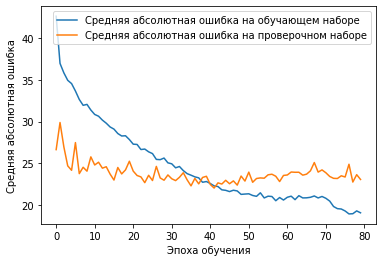

In [ ]:
plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
a = (xTrain01, xTrainRez01)
yy = model.predict(a)

In [ ]:
n = 10
for i in range(n):
  print('Реальное значение - ',yTrain[i], " Предсказанное значение - ", yy[i][0], " Разница - ", abs(yTrain[i]-yy[i][0]))

Реальное значение -  40.0  Предсказанное значение -  43.49237  Разница -  3.49237060546875
Реальное значение -  40.0  Предсказанное значение -  42.760975  Разница -  2.760974884033203
Реальное значение -  300.0  Предсказанное значение -  294.373  Разница -  5.62701416015625
Реальное значение -  180.0  Предсказанное значение -  138.74084  Разница -  41.2591552734375
Реальное значение -  40.0  Предсказанное значение -  48.926537  Разница -  8.926536560058594
Реальное значение -  200.0  Предсказанное значение -  151.1287  Разница -  48.871307373046875
Реальное значение -  120.0  Предсказанное значение -  109.59689  Разница -  10.403106689453125
Реальное значение -  50.0  Предсказанное значение -  50.443638  Разница -  0.4436378479003906
Реальное значение -  60.0  Предсказанное значение -  65.72438  Разница -  5.7243804931640625
Реальное значение -  70.0  Предсказанное значение -  66.65652  Разница -  3.3434829711914062
